# Imports



In [1]:
from google.colab import drive
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Project/"
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
import tensorflow as tf
import keras
import fnmatch
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib

from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
from matplotlib.image import imread

# Testing ResNet50 (ImageNet weights) on image slice

In [4]:
img = nib.load(basePath + "TRN_00.nii.gz")
data = img.get_fdata()
print(data[0])
print(img.get_header())
print(img.affine)

[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 ...
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  67   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.000000e+00 7.050000e-01 7.050000e-01 5.000000e+00 0.000000e+00
 1.000000e+00 1.000000e+00 5.038795e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  after removing the cwd from sys.path.


(512, 512, 67)


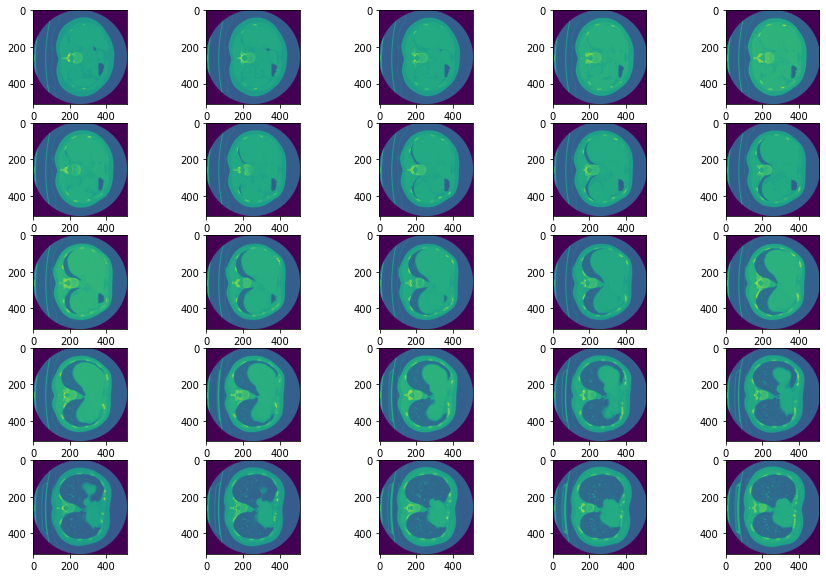

In [ ]:
print(img.shape)
for i in range(data.shape[2]):
    if i <= 24:
      plt.subplot(5, 5,i + 1)
      plt.imshow(data[:,:,0 + i])
      plt.gcf().set_size_inches(15, 10)
    else:
      break
plt.show()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

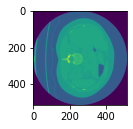

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02782093', 'balloon', 0.16421433), ('n04372370', 'switch', 0.11623082), ('n03876231', 'paintbrush', 0.10123157)]


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image

model = ResNet50(weights='imagenet')
print(model.summary())

slice = data[:, :, 0]

plt.subplot(5, 5, 1)
plt.imshow(slice)
plt.gcf().set_size_inches(15, 10)
plt.show()

matplotlib.image.imsave('slice.png', slice)

newsize = (224, 224)
im1 = Image.open("slice.png")
im1 = im1.resize(newsize)

img_path = "slice.png"

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

# Modify colab GPU memory limitations

In [6]:
tf.config.list_physical_devices('GPU')
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus:
  #tf.config.experimental.set_memory_growth(gpu, True)

# Grabbing all images into train_folders (parsed later)

In [39]:
train_folders = [f.name for f in os.scandir(basePath + "train_jpgs_folders") if f.is_dir() and not len(os.listdir(basePath + "train_jpgs_folders/" + f.name)) <= 10]
print(train_folders)

['TRN_53', 'TRN_28', 'TRN_29', 'TRN_55', 'TRN_12', 'TRN_56', 'TRN_25', 'TRN_08', 'TRN_27', 'TRN_44', 'TRN_17', 'TRN_06', 'TRN_30', 'TRN_59', 'TRN_45', 'TRN_31', 'TRN_14', 'TRN_33', 'TRN_39', 'TRN_36', 'TRN_38', 'TRN_51', 'TRN_19', 'TRN_47', 'TRN_49', 'TRN_26', 'TRN_07', 'TRN_41', 'TRN_23', 'TRN_58', 'TRN_21', 'TRN_18', 'TRN_42', 'TRN_52', 'TRN_50', 'TRN_10', 'TRN_15', 'TRN_43', 'TRN_40', 'TRN_32', 'TRN_54', 'TRN_20', 'TRN_04', 'TRN_13', 'TRN_09', 'TRN_05', 'TRN_22', 'TRN_34', 'TRN_46', 'TRN_03', 'TRN_35', 'TRN_48', 'TRN_37', 'TRN_57', 'TRN_00', 'TRN_01', 'TRN_02']


# Split images into training, validation, and testing folders

In [40]:
new_train_folders = train_folders[:-11]
validation_folders = new_train_folders[-11:]
new_train_folders = new_train_folders[:-11]
test_folders = train_folders[-11:]
print(new_train_folders)
print(len(new_train_folders))
print(validation_folders)
print(len(validation_folders))
print(test_folders)
print(len(test_folders))

['TRN_53', 'TRN_28', 'TRN_29', 'TRN_55', 'TRN_12', 'TRN_56', 'TRN_25', 'TRN_08', 'TRN_27', 'TRN_44', 'TRN_17', 'TRN_06', 'TRN_30', 'TRN_59', 'TRN_45', 'TRN_31', 'TRN_14', 'TRN_33', 'TRN_39', 'TRN_36', 'TRN_38', 'TRN_51', 'TRN_19', 'TRN_47', 'TRN_49', 'TRN_26', 'TRN_07', 'TRN_41', 'TRN_23', 'TRN_58', 'TRN_21', 'TRN_18', 'TRN_42', 'TRN_52', 'TRN_50']
35
['TRN_10', 'TRN_15', 'TRN_43', 'TRN_40', 'TRN_32', 'TRN_54', 'TRN_20', 'TRN_04', 'TRN_13', 'TRN_09', 'TRN_05']
11
['TRN_22', 'TRN_34', 'TRN_46', 'TRN_03', 'TRN_35', 'TRN_48', 'TRN_37', 'TRN_57', 'TRN_00', 'TRN_01', 'TRN_02']
11


# Resize training images from (512, 512) to (224, 224)

*May have to run this twice to get all resized image folders*

Note that Errno 17 code will execute for each time a new folder is worked on by the program

New folder make take 1-2 minutes to load in storage

In [102]:
try:
    os.mkdir(basePath + "training/resized/")
except OSError as error:
    print(error)

for folder in new_train_folders:
  dir_list = os.listdir(basePath + "train_jpgs_folders/" + folder + "/")
  for filename in dir_list:
    image = cv2.imread(basePath + "train_jpgs_folders/" + folder + "/" + filename)
    up_points = (224,224)
    resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(basePath + "training/resized/", filename), resized_down) 

[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Project/training/resized/'


# Resize validating images from (512, 512) to (224, 224)

*May have to run this twice to get all resized image folders*

Note that Errno 17 code will execute for each time a new folder is worked on by the program

New folder make take 1-2 minutes to load in storage

In [103]:
try:
    os.mkdir(basePath + "validating/resized/")
except OSError as error:
    print(error)

for folder in validation_folders:
  dir_list = os.listdir(basePath + "train_jpgs_folders/" + folder + "/")
  for filename in dir_list:
    image = cv2.imread(basePath + "train_jpgs_folders/" + folder + "/" + filename)
    up_points = (224,224)
    resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(basePath + "validating/resized/", filename), resized_down) 

[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Project/validating/resized/'


# Resize testing images from (512, 512) to (224, 224)

In [104]:
try:
    os.mkdir(basePath + "testing/resized/")
except OSError as error:
    print(error)

for folder in test_folders:
  dir_list = os.listdir(basePath + "train_jpgs_folders/" + folder + "/")

  for filename in dir_list:
    image = cv2.imread(basePath + "train_jpgs_folders/" + folder + "/" + filename)
    up_points = (224,224)
    resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(basePath + "testing/resized/", filename), resized_down) 

[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Project/testing/resized/'


# Creating .csv file of slices and respective labels (training data)

In [105]:
f1=open(basePath + "TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "training/resized/")
for file in dir_list:
  for row in reader:
    if file[:6] == row[0]:
      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)
df.to_csv(os.path.join(basePath + "training/", 'all_train.csv'))
df = df.iloc[0:0]

# Creating .csv file of slices and respective labels (validation data)

In [106]:
f1=open(basePath + "TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "validating/resized/")
for file in dir_list:
  for row in reader:
    if file[:6] == row[0]:
      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)
df.to_csv(basePath + "validating/all_validate.csv")
df = df.iloc[0:0]

# Creating .csv file of slices and respective labels (test data)

In [107]:
f1=open(basePath + "TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "testing/resized/")
for file in dir_list:
  for row in reader:
    if folder[:6] == row[0]:
      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)
df.to_csv(os.path.join(basePath + "testing/", 'all_test.csv'))
df = df.iloc[0:0]

# Resnet50 model creation (testing and validation)

In [95]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [96]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [97]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [98]:
def ResNet50(input_shape=(224, 224, 3), classes=3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # DROPOUT
    X = Dropout(0.2)(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

![link text](https://drive.google.com/uc?export=view&id=1Z_A8RiUuzLWD4bvKKMmqw4LUefkq-08Z)

In [101]:
from keras.layers.normalization.batch_normalization import BatchNormalization
import keras.backend as k

del model
k.clear_session() #Clear keras backend 
tf.compat.v1.reset_default_graph() #Clear keras backend 

TEST_SIZE = len(fnmatch.filter(os.listdir(basePath + "training/"), '*.csv'))
#print(TEST_SIZE)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


model = ResNet50()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001), loss='binary_crossentropy',metrics=['accuracy'])
#filepath= basePath + "models/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name 
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max', save_freq=5) #creating checkpoint to save the best validation accuracy
#callbacks_list = [checkpoint]

train_df = pd.read_csv(basePath + "training/all_train.csv")
validating_df = pd.read_csv(basePath + "validating/all_validate.csv")

train_dir = basePath + "training/resized/" #Add data generators for parsing images to the network while training.
test_dir = basePath + "validating/resized/" #Load the full test CSV file that includes 3927 images

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df[:],
        directory=train_dir,
        x_col="ID",
        y_col=["thick_walls", "has_calcification", "foci_around"],
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',shuffle=True,
        validate_filenames=True,
        seed=42,
        #verbose=None
        )
validation_generator = test_datagen.flow_from_dataframe(
        dataframe = validating_df[:],
        directory=test_dir,
        x_col="ID",
        y_col=["thick_walls", "has_calcification", "foci_around"],
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',shuffle=True,
        validate_filenames=True,
        seed=42,
        #verbose=None
        )
      
results = model.fit_generator(train_generator, epochs=20, 
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.n // train_generator.batch_size,
                              #callbacks=callbacks_list,
                              shuffle=True,
                              workers=8,
                              use_multiprocessing=False) #start training

Found 11965 validated image filenames.
Found 2955 validated image filenames.


![link text](https://drive.google.com/uc?export=view&id=1Wf8OQz0nZ5tIfkxIPVZpZoi2WODEbM4A)

# Graph of results on trained model

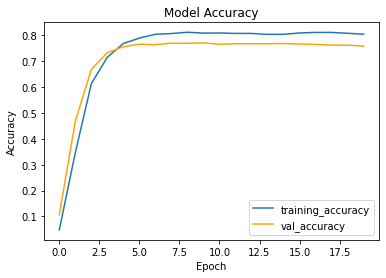

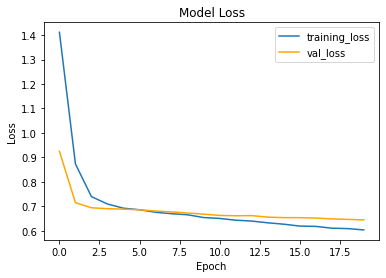

In [ ]:
plt.figure()
plt.plot(results.history['accuracy'], label="training_accuracy")
plt.plot(results.history['val_accuracy'], color="orange", label = "val_accuracy")
plt.legend(loc="lower right")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(results.history['loss'],  label="training_loss")
plt.plot(results.history['val_loss'], color="orange",  label="val_loss")
plt.legend(loc="upper right")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()